In [92]:
import os
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [93]:
def load_vector(file: str | Path) -> np.ndarray:
    vec = []
    with open(file, 'r') as f:
        for line in f.readlines():
            try:
                vec.append(float(line))
            except ValueError as e:
                raise e
    return np.array(vec, dtype=np.float64)

In [94]:
def write_vector(matrix: np.ndarray, file: str | Path, sep: str | None = '\t', in_cwd: bool = True) -> None:
    with open(Path(os.getcwd()) / file if in_cwd else file, 'a') as f:
        for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):
            f.write(sep.join(map(str, [i, j, matrix[i, j]])) + '\n')

In [95]:
def rotate_theta(theta: float) -> np.ndarray:
    """generate all rotation matrices for the angles in theta
    
    returns: (len(theta), 2, 2) matrix of stacked 2x2 rotation matrices
    """
    return np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)],
    ], dtype=np.float64)

In [96]:
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

image = shepp_logan_phantom()
image = rescale(image, scale=.4, mode='reflect', channel_axis=None)

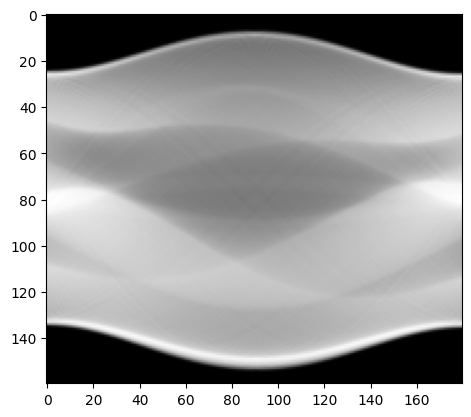

In [99]:
from radon import radon

angles = np.arange(180)
sino = radon(image, angles=angles, method='bilinear')

plt.imshow(sino, cmap=plt.cm.Greys_r)
plt.show()

FBP rms using ramp-filter gives reconstruction error: 0.028220
FBP rms using shepp-logan-filter gives reconstruction error: 0.032775
FBP rms using cosine-filter gives reconstruction error: 0.041970
FBP rms using hamming-filter gives reconstruction error: 0.049620
FBP rms using hann-filter gives reconstruction error: 0.051567


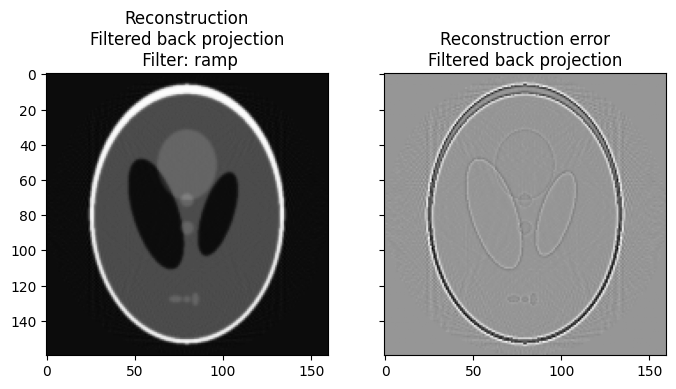

In [100]:
from skimage.transform import iradon

curr = 1.
for filter in ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']:
    reconstruction_fbp = iradon(sino, theta=angles, filter_name=filter)
    error = reconstruction_fbp - image
    errval = np.sqrt(np.mean(error ** 2))
    if errval < curr:
        best_filter = filter
        curr = errval
    print(f'FBP rms using {filter}-filter gives reconstruction error: {errval:.6f}')

reconstruction_fbp = iradon(sino, theta=angles, filter_name=best_filter)

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title(f"Reconstruction\nFiltered back projection\n Filter: {best_filter}")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()